In [96]:
import json
import pandas as pd
import numpy as np
import ast

from langchain.llms import OpenAI 
from langchain.chat_models import ChatOpenAI  
from langchain.callbacks import get_openai_callback
from langchain.schema.messages import HumanMessage, SystemMessage

In [97]:
with open("config.json", "r") as config_file:
    config = json.load(config_file)

In [98]:
openai_api_key = config["api_keys"]["openai"]

In [100]:
dataset = pd.read_csv(input("Enter testing dataset path: "))

In [101]:
with open('prompt_template.txt', 'r') as template_file:
    template = template_file.read()

In [102]:
with open('edam_topics.txt', 'r') as edam_file:
    edam_topics = edam_file.readlines()

edam_topics = [topic.strip() for topic in edam_topics]

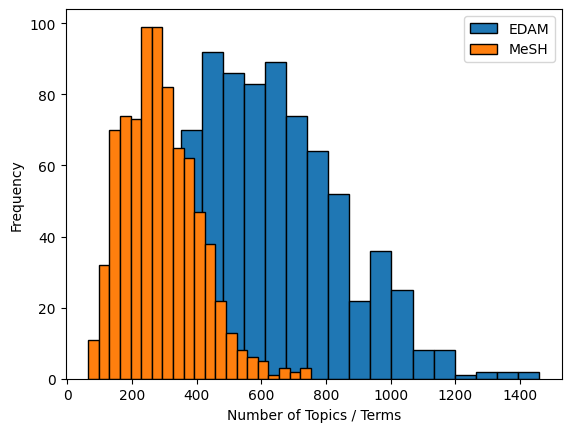

In [103]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black')
plt.hist(dataset['MeSH Terms'].apply(len), bins='auto', edgecolor='black')

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'MeSH'])

In [104]:
print("Total MeSH Terms:", len(list(dataset.iloc[0]['MeSH Terms'])))
print("Unique MeSH Terms:", len(np.unique(list(dataset.iloc[0]['MeSH Terms']))))
print()
print("Total EDAM Topics:", len(list(dataset.iloc[0]['EDAM Topics'])))
print("Unique EDAM Topics:", len(np.unique(list(dataset.iloc[0]['EDAM Topics']))))

Total MeSH Terms: 504
Unique MeSH Terms: 45

Total EDAM Topics: 1065
Unique EDAM Topics: 48


In [105]:
dataset['MeSH Terms'] = dataset['MeSH Terms'].apply(lambda mesh_list: np.unique(ast.literal_eval((mesh_list))))
dataset['EDAM Topics'] = dataset['EDAM Topics'].apply(lambda edam_list: np.unique(ast.literal_eval((edam_list))))

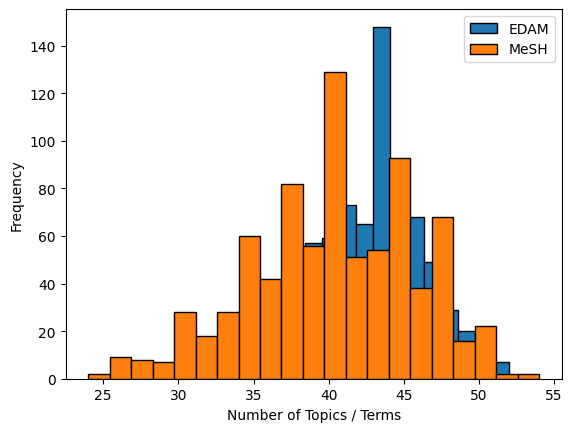

In [62]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black')
plt.hist(dataset['MeSH Terms'].apply(len), bins='auto', edgecolor='black')

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'MeSH'])

## OpenAI API

Let's start with a proof of concept:

In [30]:
abstract, edam_topics = dataset.iloc[0][['Abstract', 'EDAM Topics']]
mesh_terms = list(edam_topics)

In [31]:
prompt = template.replace('<abstract>', abstract).replace('<num_terms>', str(len(edam_topics)))

In [32]:
print(prompt)

I have an abstract associated with a scientific dataset quoted here: 
"Nuclear export of mRNA is mediated by a complex machinery of RNA-binding proteins that recognizes and routes mRNAs through a messenger ribonucleoprotein (mRNP) network. The full spectrum of mRNA cargoes for any dedicated mRNA export factor is unknown. We identified the mRNAs that bind two conserved yeast mRNA export factors, Yra1 (refs. 1-5) and Mex67 (refs. 6,7), on a genome-wide scale and determined their level of binding. Yra1 and Mex67 bind approximately 1,000 and 1,150 mRNAs, respectively, corresponding to almost 20% of the yeast genome and roughly 36% of all transcriptional events each. The binding level of Yra1 targets is related to their transcriptional frequency, but that of Mex67 targets is not. Yra1-bound transcripts are enriched in mRNAs that are regulated by a number of transcription factors. Yra1- and Mex67-bound populations also show enrichment of mRNAs encoding distinct functional classes of proteins

In [33]:
messages = [
    SystemMessage(content="You're a helpful assistant"),
    HumanMessage(content=prompt)
]

chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    openai_api_key = openai_api_key
)

In [34]:
with get_openai_callback() as cb:
    chat.invoke(messages)
    for chunk in chat.stream(messages):
        print(chunk.content, end="", flush=True)
    print("\n===========CALLBACK: ==========\n")
    print(cb)
    print("\n=============\n")

Biochemistry, Computational biology, Genetics, Genomics, Molecular biology, RNA, Transcriptomics, Cell biology, Protein interactions, Protein expression, Protein modifications, Protein properties, Gene expression, Gene regulation, Transcription factors and regulatory sites, Molecular interactions, pathways and networks, Systems biology, Epigenetics, Biomarkers, Functional genomics, DNA replication and recombination, DNA binding sites, DNA mutation, DNA packaging, Comparative genomics, Genotype and phenotype, Genomic variation, Evolutionary biology, Proteomics, Structural biology, Bioinformatics, Data integration and warehousing, Data mining, Data visualization, Database management, Laboratory techniques, Medical informatics, Gene structure, RNA splicing, RNA-Seq, Sequence analysis, Sequencing, Machine learning, Computational chemistry, Drug discovery, Drug development, Pharmacology, Molecular medicine.
===========CALLBACK: ==========

Tokens Used: 1588
	Prompt Tokens: 1541
	Completion 

In [36]:
gpt_output = "Biochemistry, Computational biology, Genetics, Genomics, Molecular biology, RNA, Transcriptomics, Cell biology, Protein interactions, Protein expression, Protein modifications, Protein properties, Gene expression, Gene regulation, Transcription factors and regulatory sites, Molecular interactions, pathways and networks, Systems biology, Epigenetics, Biomarkers, Functional genomics, DNA replication and recombination, DNA binding sites, DNA mutation, DNA packaging, Comparative genomics, Genotype and phenotype, Genomic variation, Evolutionary biology, Proteomics, Structural biology, Bioinformatics, Data integration and warehousing, Data mining, Data visualization, Database management, Laboratory techniques, Medical informatics, Gene structure, RNA splicing, RNA-Seq, Sequence analysis, Sequencing, Machine learning, Computational chemistry, Drug discovery, Drug development, Pharmacology, Molecular medicine".split(", ")

In [48]:
not_in_edam = 0

true_topics = dataset.iloc[0]['MeSH Terms']
num_correct = 0

for topic in gpt_output:
    if topic not in edam_topics:
        not_in_edam += 1
        continue

    if topic in true_topics:
        num_correct += 1

In [49]:
print("GPT-outputted topics not in EDAM:", not_in_edam)
print("# Correct topics from GPT:", num_correct)
print("# Missing topics from GPT:", len(true_topics) - num_correct)

GPT-outputted topics not in EDAM: 4
# Correct topics from GPT: 0
# Missing topics from GPT: 45


In [63]:
dataset

,Unnamed: 0,PMID,Abstract,MeSH Terms,EDAM Topics
0,0,12524544,Nuclear export of mRNA is mediated by a comple...,"[ , ', ,, -, A, B, C, D, E, F, G, H, I, M, N, ...","[ , ', (, ), ,, -, A, B, C, D, F, G, H, I, L, ..."
1,1,14512514,"The synthesis of fatty acids and cholesterol, ...","[ , ', ,, -, 1, 2, A, B, C, D, E, F, G, I, K, ...","[ , ', (, ), ,, -, A, D, E, G, L, M, N, P, R, ..."
2,2,14981237,"RNase E, an essential endoribonuclease of Esch...","[ , ', ,, -, A, B, E, G, H, L, M, N, O, P, R, ...","[ , ', ,, -, A, B, D, G, I, L, M, N, P, R, S, ..."
3,3,15054141,Diminished activity of peroxisome proliferator...,"[ , ', ,, 5, 7, A, B, C, E, F, G, H, I, L, M, ...","[ , ', ,, A, F, G, H, I, L, M, N, P, Q, R, S, ..."
4,4,15129285,The flood of high-throughput biological data h...,"[ , ', ,, A, B, C, E, G, M, P, S, [, ], a, b, ...","[ , ', (, ), ,, A, B, C, D, E, G, I, K, L, M, ..."
...,...,...,...,...,...
810,810,35986171,"Every day, we sleep for a third of the day. Sl...","[ , ', ,, A, D, H, P, S, T, [, ], a, c, e, i, ...","[ , ', ,, -, A, C, D, H, N, P, R, S, T, [, ], ..."
811,811,36171374,Oxidative genome damage is an unavoidable cons...,"[ , ', ,, A, C, D, G, H, I, M, N, O, P, R, S, ...","[ , ', ,, A, C, D, E, G, I, K, M, N, P, R, S, ..."
812,812,36179935,Molecular mechanisms underlying cognitive defi...,"[ , ', ,, A, C, D, F, G, H, M, S, T, [, ], a, ...","[ , ', ,, A, C, D, E, I, L, M, N, P, R, T, Z, ..."
813,813,37586364,To evaluate whether nicotinamide adenine dinuc...,"[ , ', ,, -, 1, 2, A, D, E, F, H, I, N, O, P, ...","[ , ', ,, D, H, I, N, P, R, S, T, V, [, ], a, ..."
